<h2> Предварительная формулировка задачи: </h2>

<h3> Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

## Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

<h2> Предварительный план работы: </h2>

**1. Анализ данных:**
    
    1.1 Анализ имеющихся признаков и прездварительная оценка их качества
    
    1.2 Отбор вопросов по имеющимся данным, дополнение / очистка данных
    
    1.3 Анализ ТЗ: уточнение формата конечного результата
    
**2. Обработка данных для построения модели**
    
    2.1 Обработка и удаление лишних признаков и пропусков
    
    2.2 Обработка признаков для обучения модели: выделение тренировочной и тестовой выборок, стандартизация
    
**3. Тестирование модели и выбор лучшей**

**4. Оформление выводов и результатов**

In [51]:
!pip install xgboost
!pip install catboost
!pip install lightgbm

In [52]:
!pip install tensorflow

In [135]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance

from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb
import xgboost as xgb
import catboost
from catboost import CatBoostRegressor, Pool

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


plt.style.use('seaborn-poster')
colors = sns.color_palette("deep")

In [54]:
#функция для открытия датасетов

def openfunc(link):
    df = pd.read_csv(link)
    display(df.info(), df.head(15))
    print('Количество партий:', df.nunique()['key'])
    return df

In [55]:
try:
    df_arc = openfunc('/Users/stepan5dol/Downloads/final_steel/data_arc.csv')
except: 
    df_arc = openfunc('/datasets/final_steel/data_arc.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


Количество партий: 3214


Данные об электродах содержат: `номер партии`, `время начала нагрева`, `конец нагрева`, `активную мощность` и `реактивную мощность`.

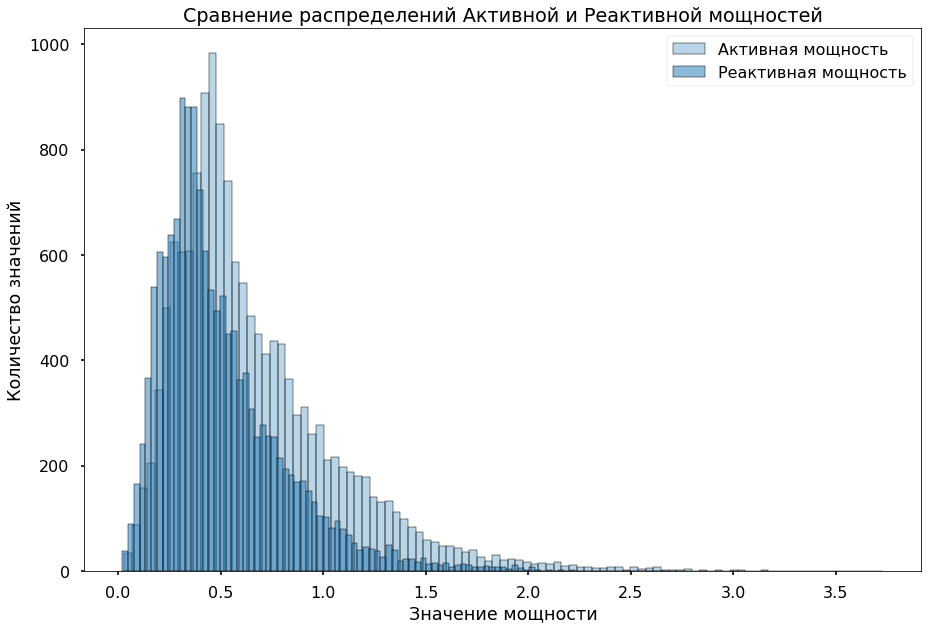

In [56]:
plt.figure(figsize=(15,10))
sns.histplot(df_arc['Активная мощность'], alpha=0.3)
sns.histplot(df_arc[df_arc['Реактивная мощность']>=0]['Реактивная мощность'], alpha=0.5)
plt.title('Сравнение распределений Активной и Реактивной мощностей')
plt.xlabel('Значение мощности')
plt.ylabel('Количество значений')
plt.legend(['Активная мощность', 'Реактивная мощность'])
plt.show()

In [57]:
df_arc['Активная мощность'].corr(df_arc['Реактивная мощность'])

0.0544372433969374

In [58]:
try:
    df_bulk_time = openfunc('/Users/stepan5dol/Downloads/final_steel/data_bulk_time.csv')
except: 
    df_bulk_time = openfunc('/datasets/final_steel/data_bulk_time.csv')
df_bulk_time['key'].max()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


Количество партий: 3129


3241

In [59]:
try:
    df_bulk = openfunc('/Users/stepan5dol/Downloads/final_steel/data_bulk.csv')
except: 
    df_bulk = openfunc('/datasets/final_steel/data_bulk.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


Количество партий: 3129


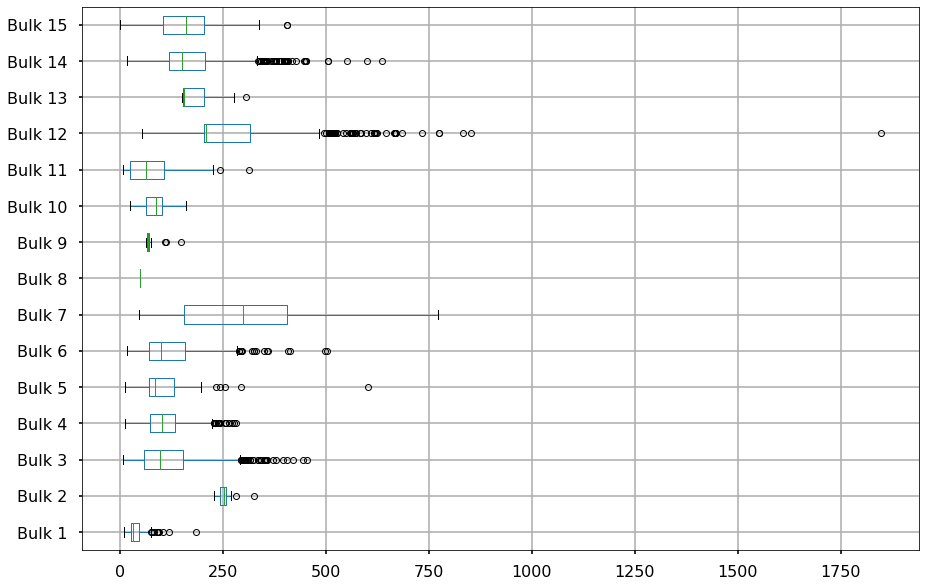

In [60]:
plt.figure(figsize=(15, 10))
df_bulk.boxplot([col for col in df_bulk.columns if col != 'key'], vert=False)
plt.show()

**Подача сыпучих материалов:**

1. Меньше всего подавали материал `под номером 8` – единожды.
2. Данные `по 12 материалу` содержат очевидный выброс, который необходимо убрать.
3. Многие материалы `(1, 3, 4, 5, 6, 12, 14)` содержат выбросы в значениях подачи. 

Остается открытым вопрос о том, есть ли единая технология или каждая партия индивидуальна. 
Возможно, столбцы с материалами, подаваемыми реже всего, `придется исключить (2, 5, 7, 8, 9, 13)`.

In [61]:
try:
    df_gas = openfunc('/Users/stepan5dol/Downloads/final_steel/data_gas.csv')
except: 
    df_gas = openfunc('/datasets/final_steel/data_gas.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


Количество партий: 3239


<AxesSubplot:>

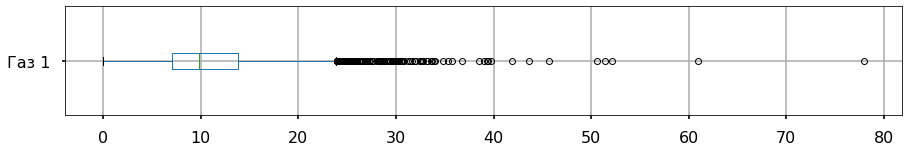

In [62]:
plt.figure(figsize=(15, 2))
df_gas.boxplot(['Газ 1'], vert=False)

**Продувка сплава газом:**

1. Указано, что сплав продувается каждый раз после добавления лигирующего материала – `уточнить технологию у заказчика`.
2. Каковы единицы измерения – м2? Это общий объем всего газа? Судя по названию столбца – это `только первая продувка`. Возможно, данные не полны. 

In [63]:
try:
    df_temp = openfunc('/Users/stepan5dol/Downloads/final_steel/data_temp.csv')
except: 
    df_temp = openfunc('/datasets/final_steel/data_temp.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


Количество партий: 3216


In [64]:
df_temp['key'].describe()

count    15907.000000
mean      1607.880870
std        942.212073
min          1.000000
25%        790.000000
50%       1618.000000
75%       2427.000000
max       3241.000000
Name: key, dtype: float64

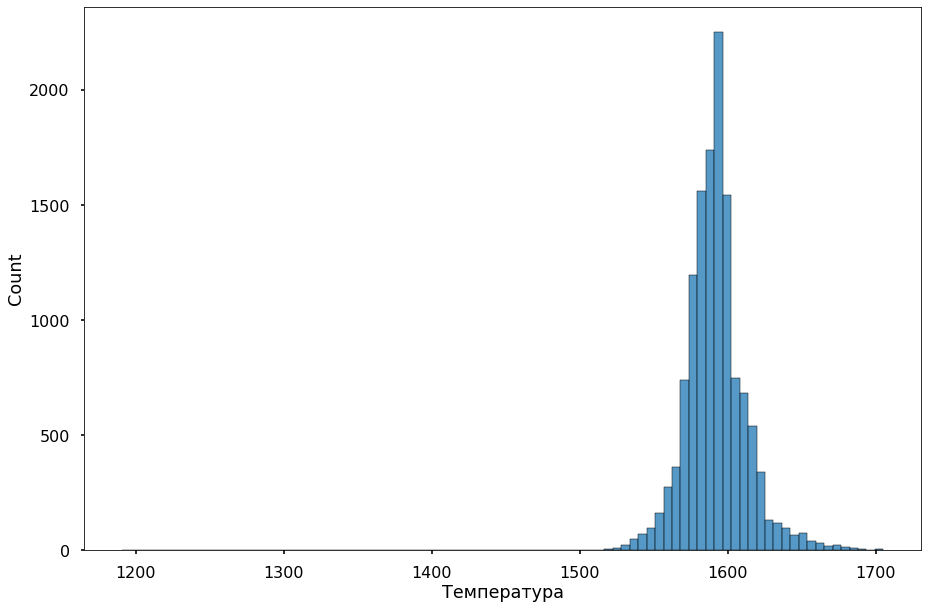

In [65]:
plt.figure(figsize=(15,10))
sns.histplot(df_temp['Температура'], bins=90)
plt.show()

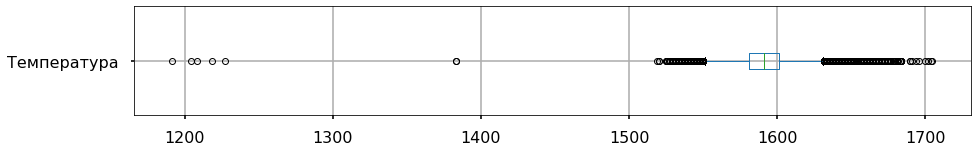

In [66]:
plt.figure(figsize=(15,2))
df_temp.boxplot(['Температура'], vert=False)
plt.show()

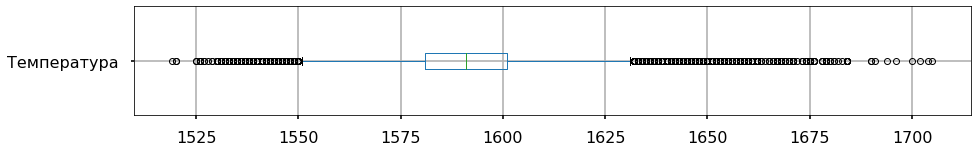

In [67]:
temp_norm = df_temp[df_temp['Температура'] > 1500]
plt.figure(figsize=(15,2))
temp_norm.boxplot(['Температура'], vert=False)
plt.show()

**Анализ температуры:**

1. Значения температуры похожи на нормальное распределение от 1550 до 1625 градусов.
2. Есть выбросы менее 1200 градусов – уточнить у заказчика, какие температуры возможны в тех.процессе.

In [68]:
try:
    df_wire_time = openfunc('/Users/stepan5dol/Downloads/final_steel/data_wire_time.csv')
except: 
    df_wire_time = openfunc('/datasets/final_steel/data_wire_time.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Количество партий: 3081


In [69]:
try:
    df_wire = openfunc('/Users/stepan5dol/Downloads/final_steel/data_wire.csv')
except: 
    df_wire = openfunc('/datasets/final_steel/data_wire.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Количество партий: 3081


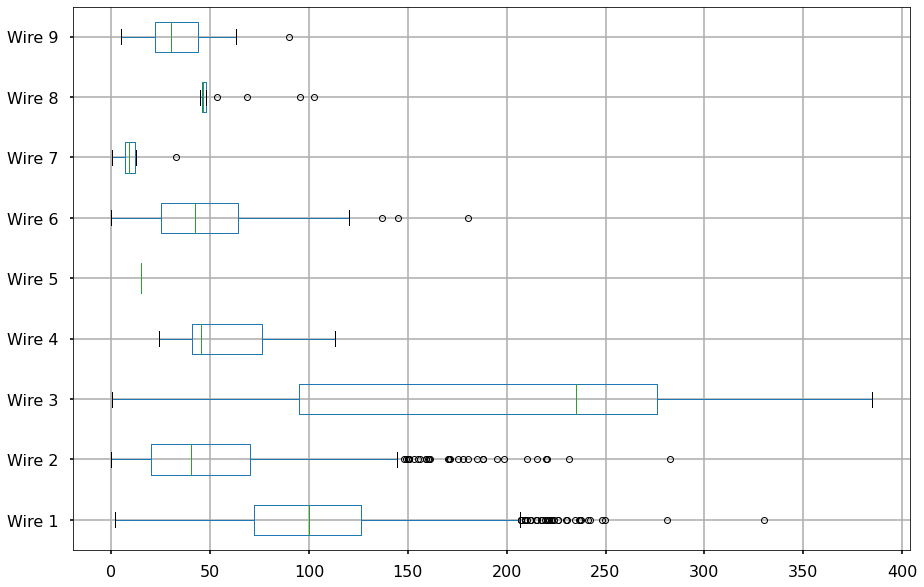

In [70]:
plt.figure(figsize=(15, 10))
df_wire.boxplot([col for col in df_wire.columns if col != 'key'], vert=False)
plt.show()

**Подача проволочных материалов:**

1. Данных о подаче `материалов 3-9 крайне мало`. Возможно, их также необхнодимо будет исключить для корректной работы модели. 
2. Много выбросов в `материалах 1 и 2`

В колонке `key` таблицы `Температура` 3216 уникальных значений, однако последняя партия идет под номером 3241. Так как температура – целевой признак, анализ будет идти только по имеющимся патриям. Необходимо узнать, каких партий нет в данной таблице, и где еще они отсутсвуют.

In [71]:
def absc(df):
    keys = df['key'].unique().tolist()
    exc = []
    for i in range(1, 3242):
        if i not in keys:
            exc.append(i)
    print('\nПропущенные значения в таблице', exc)
    print('\nКоличество пропущенных партий:', len(exc))
    print('------------------------------------------')
    return pd.DataFrame(exc)

In [72]:
keys_temp = absc(df_temp)
keys_arc = absc(df_arc)
keys_bulk = absc(df_bulk)
keys_bulk_time = absc(df_bulk_time)
keys_gas = absc(df_gas)
keys_wire = absc(df_wire)
keys_wire_time = absc(df_wire_time)


Пропущенные значения в таблице [41, 42, 355, 382, 506, 529, 540, 607, 683, 710, 766, 1133, 1300, 1437, 2031, 2103, 2278, 2356, 2373, 2446, 2469, 2491, 2683, 3200, 3207]

Количество пропущенных партий: 25
------------------------------------------

Пропущенные значения в таблице [41, 42, 195, 279, 355, 382, 506, 529, 540, 607, 683, 710, 766, 1133, 1300, 1437, 2031, 2103, 2278, 2356, 2373, 2446, 2469, 2491, 2683, 3200, 3207]

Количество пропущенных партий: 27
------------------------------------------

Пропущенные значения в таблице [41, 42, 51, 52, 53, 54, 55, 56, 72, 80, 81, 110, 151, 188, 195, 225, 269, 302, 330, 331, 332, 343, 350, 355, 382, 506, 529, 540, 607, 661, 683, 710, 766, 830, 874, 931, 933, 934, 960, 961, 964, 966, 983, 984, 1062, 1105, 1133, 1221, 1268, 1300, 1334, 1402, 1437, 1517, 1518, 1535, 1566, 1623, 1656, 1783, 1818, 1911, 1959, 1974, 1979, 2009, 2010, 2031, 2043, 2056, 2103, 2195, 2196, 2197, 2198, 2216, 2217, 2231, 2278, 2310, 2356, 2373, 2390, 2408, 2434, 2446, 

<h3> Предварительный вывод </h3>

Температура является целевым признаком, но какая – не указано. Очень много пропусков ключей – необходимо разобраться, с чем связаны эти пропуски. Работа электродов должна совпадать с добавлением материалов – но, судя по пропускам в ключах, это не так. Например, образец 382 ни разу не нагревался, но при этом не присутствует в пропусках в остальных таблицах. Стоит ли удалить все "ненагретые" образцы? Среди сыпучих материалов выделены основные – добавляемые чаще всего. Остальные добавляются крайне редно, что может помешать в анализе модели. Либо придется заменить их количество нулями. Часто встречающихся проволочных материалов еще меньше – всего два. Судя по данным, газ добавлялся лишь единожны, что тоже не отражает описанный выше процесс. 

После ответов на нижеизложенные вопросы таблицы будут объединены. Наиболее важные показатели: 

    1. Целевой признак: температура по указанию заказчика, либо от 1500 до максимальной в датасете.
    2. Активная и Реактивная мощности электродов.
    3. Сыпучие материалы под номерами 1, 3, 4, 6, 12, 14
    4. Проволочные материалы под нимерами 1 и 2
    5. Значения из таблицы Газ 1. 
    
Далее – очистка от пропусков и выбросов признаках, train/test split и обучение модели.

<h3> Вопросы заказчику: </h3>

1. Температуру на каком этапе необходимо предсказать? Целевой признак – конечная температура?

2. Чему соответствуют пропуски пробников в таблицах? Есть ли у заказчика пропущенные значения?

    3.1 Означают ли пропуски в таблице с работой электродов, что сплав вообще не нагревали? Либо в тот момент не работал датчик?
    
    3.2 Означают ли пропуски в таблице с сыпучими материалами, что их не добавляли в расплав?
    
    3.3 Означают ли пропуски в таблице с проволочными материалами, что их не добавляли в расплав?
    
    
3. Почему колонка с подачей инертного газа лишь одна (Газ 1)? Указан общий объем подаваемого газа, или это только первая/последняя продувка?

4. Каковы границы допустимой температуры?

<h3> Формирование конечной таблицы с целевым признаком – конечной температурой. </h3>

In [73]:
temp = df_temp[df_temp['Температура'].notna()]
#temp['Время замера'] = pd.to_datetime(temp['Время замера'], format='%Y-%m-%d %H:%M:%S')
temp = temp[temp['Температура'] > 1450]
aggr = temp.groupby(by='key', as_index=False).count()
aggr = aggr[aggr['Температура'] > 1]
needed_keys = aggr['key'].tolist()
temp

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15878,3237,2019-08-31 22:44:04,1569.0
15883,3238,2019-08-31 23:30:31,1584.0
15886,3239,2019-09-01 01:31:47,1598.0
15894,3240,2019-09-01 02:39:01,1617.0


In [74]:
temp_new = temp.groupby('key').agg('min')['Время замера']
temp_new = pd.DataFrame(temp_new)
temp_new = temp_new.merge(df_temp, on='Время замера', how='left')
temp_new.set_axis(['Время первого замера','key','Начальная температура'], axis = 'columns', inplace = True)
temp_new

,Время первого замера,key,Начальная температура
0,2019-05-03 11:16:18,1,1571.0
1,2019-05-03 11:37:27,2,1581.0
2,2019-05-03 12:13:17,3,1596.0
3,2019-05-03 12:52:57,4,1601.0
4,2019-05-03 13:23:19,5,1576.0
...,...,...,...
3210,2019-08-31 22:44:04,3237,1569.0
3211,2019-08-31 23:30:31,3238,1584.0
3212,2019-09-01 01:31:47,3239,1598.0
3213,2019-09-01 02:39:01,3240,1617.0


In [75]:
temp_target = temp.groupby('key').agg('max')['Время замера']
temp_target = pd.DataFrame(temp_target)
temp_target = temp_target.merge(temp, on='Время замера', how='left')
temp_target.set_axis(['Время последнего замера','key','Конечная температура'], axis = 'columns', inplace = True)
temperature = temp_new.merge(temp_target, how='inner', on='key')
temperature = temperature.drop(columns=['Время последнего замера', 'Время первого замера'])
temperature = temperature.set_index('key')
temperature = temperature.iloc[needed_keys]
temperature

,Начальная температура,Конечная температура
key,,
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0
6,1543.0,1596.0
...,...,...
2518,1563.0,1563.0
2519,1569.0,1569.0
2520,1605.0,1605.0


In [76]:
df_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


Для создания признака в таблице `df_arc` воспользуемся формулой:

$$ E = t * \sqrt{P^2 + Q^2} $$

где 

`Е - энергия`,

`P – активная мощность`,

`Q – реактивная мощность`,

`t – время нагрева`.

In [77]:
arc = df_arc.copy()
arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
arc['Время нагрева'] = (arc['Конец нагрева дугой'] - arc['Начало нагрева дугой']).dt.total_seconds().astype(int)
arc['Энергия'] = arc['Время нагрева'] * ((arc['Активная мощность']**2) + (arc['Реактивная мощность']**2))**0.5
arc_feat = arc.groupby(by='key').agg(sum).drop(columns=['Активная мощность', 'Реактивная мощность']).reset_index(col_level=True).set_index('key')
arc_feat

,Время нагрева,Энергия
key,,
1,1098,1442.377754
2,811,881.233565
3,655,525.066777
4,741,796.911309
5,869,1199.137958
...,...,...
3237,909,958.336236
3238,546,555.867370
3239,1216,1013.067719


In [78]:
wire = df_wire.copy().fillna(0).drop(columns=['Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'])
wire = wire.set_index('key')
wire

,Wire 1,Wire 2
key,,
1,60.059998,0.00000
2,96.052315,0.00000
3,91.160157,0.00000
4,89.063515,0.00000
5,89.238236,9.11456
...,...,...
3237,38.088959,0.00000
3238,56.128799,0.00000
3239,143.357761,0.00000


In [79]:
bulk = df_bulk.drop(columns=['Bulk 2', 'Bulk 5', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 13'])
#bulk = bulk[bulk['Bulk 12'] < 1000]
bulk = bulk.fillna(0).astype(int)
bulk = bulk.set_index('key')
bulk

,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15
key,,,,,,,,,
1,0,0,43,0,0,0,206,150,154
2,0,0,73,0,0,0,206,149,154
3,0,0,34,0,0,0,205,152,153
4,0,0,81,0,0,0,207,153,154
5,0,0,78,0,0,0,203,151,152
...,...,...,...,...,...,...,...,...,...
3237,0,170,0,0,0,0,252,130,206
3238,0,126,0,0,0,0,254,108,106
3239,0,0,0,114,0,0,158,270,88


In [80]:
df_gas = df_gas.set_index('key')
data = temperature.join(arc_feat, how='inner').join(df_gas, how='inner').join(wire, how='inner').join(bulk, how='inner')
data

,Начальная температура,Конечная температура,Время нагрева,Энергия,Газ 1,Wire 1,Wire 2,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,,
2,1581.0,1602.0,811,881.233565,12.555561,96.052315,0.000000,0,0,73,0,0,0,206,149,154
3,1596.0,1599.0,655,525.066777,28.554793,91.160157,0.000000,0,0,34,0,0,0,205,152,153
4,1601.0,1625.0,741,796.911309,18.841219,89.063515,0.000000,0,0,81,0,0,0,207,153,154
5,1576.0,1602.0,869,1199.137958,5.413692,89.238236,9.114560,0,0,78,0,0,0,203,151,152
6,1543.0,1596.0,952,1410.747219,11.273392,99.109917,9.114560,0,0,117,0,0,0,204,201,154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2518,1563.0,1563.0,876,840.123184,10.314704,135.189595,101.156639,0,0,0,50,0,90,0,152,0
2519,1569.0,1569.0,817,992.868994,13.340452,86.835838,97.989833,0,0,0,30,0,46,0,122,0
2520,1605.0,1605.0,643,415.892913,20.626015,170.220963,115.301681,0,0,0,184,0,90,0,252,0


<h3> Вывод 2 </h3>
Конечная таблица сформирована, явные "ненужные" выбросы убраны из таблицы.

In [81]:
RS = np.random.RandomState(100423)
CV = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RS)

In [82]:
features = data.drop(columns=['Конечная температура'])
target = data['Конечная температура']

features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.2, 
                                                                            random_state=RS)

In [83]:
pipe_forest = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', RandomForestRegressor(random_state=RS))
])

params_forest = {'reg__n_estimators': range(50, 150, 10),
                 'reg__max_depth': range(2, 8),
                 'reg__min_samples_leaf': range(1, 5)}

forest_grid = RandomizedSearchCV(pipe_forest, params_forest, cv=CV, scoring='neg_mean_absolute_error', n_jobs=-1)
forest_grid.fit(features_train, target_train)

display(forest_grid.best_params_)
display(-forest_grid.best_score_)
display(forest_grid.best_estimator_)

/Users/stepan5dol/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/Users/stepan5dol/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/Users/stepan5dol/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


{'reg__n_estimators': 120, 'reg__min_samples_leaf': 1, 'reg__max_depth': 7}

6.370216303184069

Pipeline(steps=[('scaler', StandardScaler()),
                ('reg',
                 RandomForestRegressor(max_depth=7, n_estimators=120,
                                       random_state=RandomState(MT19937) at 0x7FE29349EC40))])

In [84]:
pipe_lgb = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', lgb.LGBMRegressor(boosting_type='gbdt',
                         objective = 'regression'))
])

params_lgb = {'reg__n_estimators': range(50, 150, 10),
                 'reg__max_depth': range(2, 8),
                 'reg__learning_rate': [0.001, 0.05, 0.1]}

lgb_grid = RandomizedSearchCV(pipe_lgb, params_lgb, cv=CV, scoring='neg_mean_absolute_error', n_jobs=-1)
lgb_grid.fit(features_train, target_train)

display(lgb_grid.best_params_)
display(-lgb_grid.best_score_)
display(lgb_grid.best_estimator_)

/Users/stepan5dol/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/Users/stepan5dol/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/Users/stepan5dol/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


{'reg__n_estimators': 90, 'reg__max_depth': 6, 'reg__learning_rate': 0.05}

6.188655466632621

Pipeline(steps=[('scaler', StandardScaler()),
                ('reg',
                 LGBMRegressor(learning_rate=0.05, max_depth=6, n_estimators=90,
                               objective='regression'))])

In [85]:
pipe_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', xgb.XGBRegressor(booster='gbtree',
                             verbosity=0))
])

params_xgb = {'reg__n_estimators': range(50, 150, 10),
                 'reg__max_depth': range(2, 8),
                 'reg__learning_rate': [0.001, 0.05, 0.1]}

xgb_grid = RandomizedSearchCV(pipe_xgb, params_xgb, cv=CV, scoring='neg_mean_absolute_error', n_jobs=-1)
xgb_grid.fit(features_train, target_train)

display(xgb_grid.best_params_)
display(-xgb_grid.best_score_)
display(xgb_grid.best_estimator_)

/Users/stepan5dol/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/Users/stepan5dol/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/Users/stepan5dol/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/Users/stepan5dol/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/stepan5dol/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: Fut

{'reg__n_estimators': 110, 'reg__max_depth': 4, 'reg__learning_rate': 0.1}

6.234051487350004

Pipeline(steps=[('scaler', StandardScaler()),
                ('reg',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=4, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=110, n_jobs=8, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=0))])

In [86]:
pipe_cat = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', CatBoostRegressor(verbose=False))
])

params_cat = {'reg__max_depth': range(7, 8),
              'reg__learning_rate': [0.01]}

cat_grid = RandomizedSearchCV(pipe_cat, params_cat, cv=CV, scoring='neg_mean_absolute_error', n_jobs=-1)
cat_grid.fit(features_train, target_train)

display(cat_grid.best_params_)
display(-cat_grid.best_score_)
display(cat_grid.best_estimator_)

/Users/stepan5dol/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/stepan5dol/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/Users/stepan5dol/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/Users/stepan5dol/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


{'reg__max_depth': 7, 'reg__learning_rate': 0.01}

6.159944247427585

Pipeline(steps=[('scaler', StandardScaler()),
                ('reg',
                 <catboost.core.CatBoostRegressor object at 0x7fe292371250>)])

In [137]:
from time import time
start = time()
def baseline_model():
    model = Sequential()
    # Add the layers
    model.add(Dense(64, input_dim=15, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation=None))

    # Compile the model
    model.compile(loss='mean_absolute_error', optimizer=Adam(lr=0.01), metrics=['mean_absolute_error'])
    return model

pipe_keras = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', KerasRegressor(build_fn=baseline_model, epochs=150, batch_size=64, verbose=0))
    
])

results_keras = cross_val_score(pipe_keras, features_train, target_train, cv=CV)
print(-results_keras.mean(), time() - start)

/var/folders/1h/bbf3n02x7d9b7ct89gds69dw0000gp/T/ipykernel_8801/2793428841.py:23: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ('reg', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=64, verbose=0))
/Users/stepan5dol/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


/Users/stepan5dol/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/Users/stepan5dol/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


1521.8518880208333 128.62003302574158


In [138]:
pipe_keras.fit(features_train, target_train)
res = pipe_keras.predict(features_test)
display(mean_absolute_error(target_test, res))

1505.4093809086878

**К сожалению, лишь модель на библиотеке Keras не достигла целевой метрики.**

<h3>Важность признаков и выводы </h3>

In [87]:
def pipeline_1(model):    
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('reg', model)
    ])
    res = cross_val_score(pipe, 
                          features_train, 
                          target_train, 
                          scoring='neg_mean_absolute_error', 
                          cv=CV)
    pipe.fit(features_train, target_train)
    return abs(res).mean()

In [98]:
model_forest = RandomForestRegressor(random_state=RS, 
                                     n_estimators= 70, 
                                     min_samples_leaf = 4, 
                                     max_depth = 6)

model_lgb = lgb.LGBMRegressor(random_state=RS,
                              boosting_type='gbdt',
                              objective = 'regression',
                              n_estimators = 90,
                              max_depth = 4,
                              learning_rate = 0.05)

model_xgb = xgb.XGBRegressor(random_state=RS,
                             booster='gbtree',
                             verbosity=0, 
                             n_estimators = 80, 
                             max_depth = 5, 
                             learning_rate = 0.1)

model_cat = CatBoostRegressor(verbose=False, 
                              max_depth = 7,
                              learning_rate = 0.01,
                              random_state=100423)

In [99]:
forest = pipeline_1(model_forest)
lgbr = pipeline_1(model_lgb)
xgbr = pipeline_1(model_xgb)
cat = pipeline_1(model_cat)

table = pd.DataFrame({'Name': ['RandomForest', 'LGBMR', 'XGBR', 'Catboost'],
                      'Result_train': [forest, lgbr, xgbr, cat]})
table.style.highlight_min(color = 'lightgreen')

/Users/stepan5dol/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/Users/stepan5dol/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/Users/stepan5dol/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/Users/stepan5dol/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/Users/stepan5dol/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 

,Name,Result_train
0,RandomForest,6.418260
1,LGBMR,6.244577
2,XGBR,6.228111
3,Catboost,6.149789


<b> Лучший разультат как на тренировочной выборке с кросс-валидацией, так и на тестовой, показала модель CatBoost. 

In [100]:
#тест CatBoost
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', CatBoostRegressor(verbose=False,
                              max_depth = 7,
                              learning_rate = 0.01))
])
pipe.fit(features_train, target_train)
test = pipe.predict(features_test)
display(f'Результат CatBoost на тестовой выборке: {mean_absolute_error(target_test, test)}')

'Результат CatBoost на тестовой выборке: 5.6670247702758365'

**Catboost показал значительный результат на тестовой выборке.**

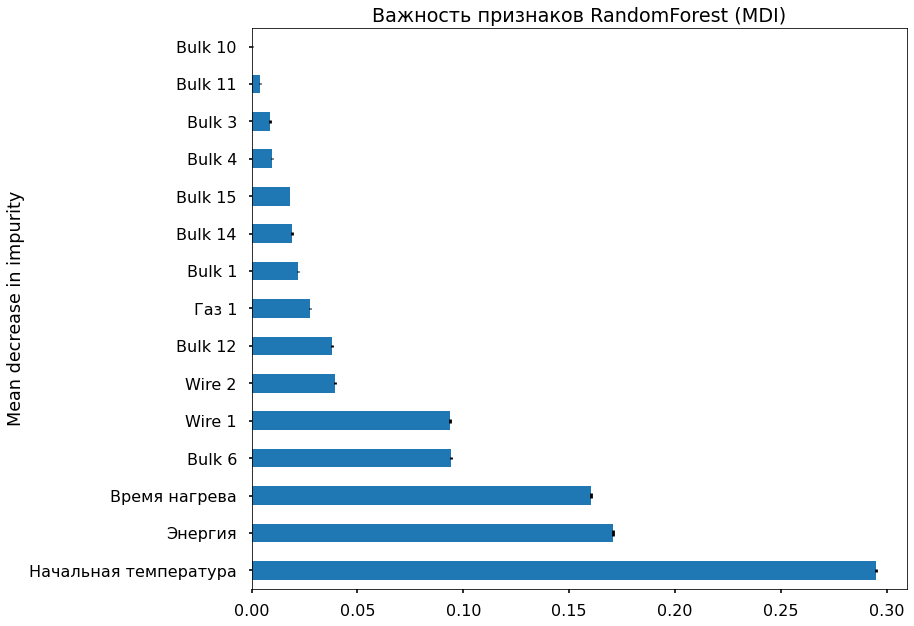

In [101]:
#RandomForest
importances = model_forest.feature_importances_
forest_importances = pd.Series(importances, index=features_train.columns )
std = np.std([tree.feature_importances_ for tree in model_forest.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.sort_values(ascending=False).plot(kind='barh', yerr=std, ax=ax)
ax.set_title("Важность признаков RandomForest (MDI)")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

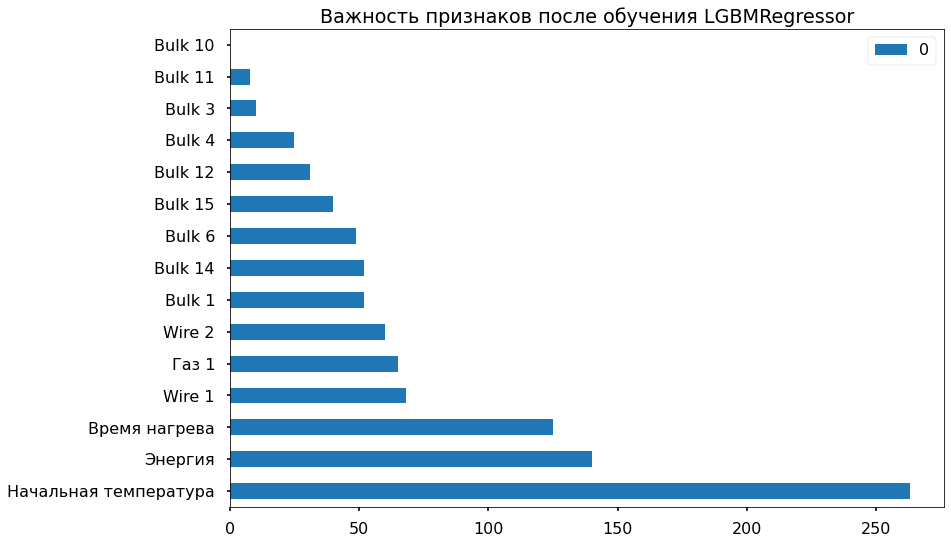

In [102]:
#lgbm
importance = pd.DataFrame(model_lgb.feature_importances_, index=features_train.columns)
importance.sort_values(by=[0], ascending=False).plot(kind='barh')
plt.title('Важность признаков после обучения LGBMRegressor')
plt.show()

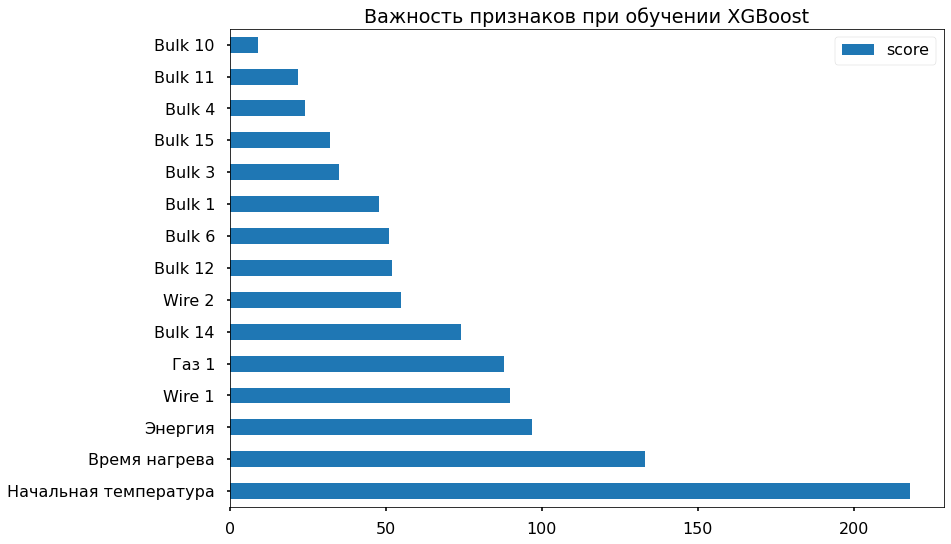

In [103]:
#xgboost
feature_important = model_xgb.get_booster().get_score(importance_type='weight')
keys = features_train.columns       #list(feature_important.keys())
values = list(feature_important.values())

data_1 = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data_1.plot(kind='barh')
plt.title('Важность признаков при обучении XGBoost')
plt.show()

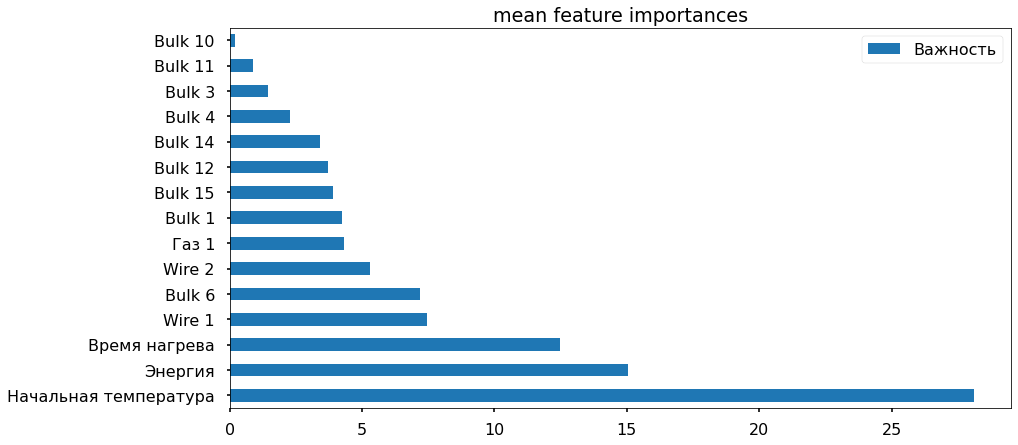

In [134]:
#Catboost
regressor = pipe.named_steps['reg']
importances = regressor.get_feature_importance()
column_names = features_train.columns
feature_importances = pd.DataFrame(importances, 
                                   column_names, 
                                   columns=['Важность']).sort_values(by='Важность',
                                                                     ascending=False)
feature_importances.plot(kind='barh', figsize=[14,7], title='mean feature importances')
plt.show()

permutation_importance из sklearn и возьмем оттуда средние значения importance 

importances = permutation_importance(model, features_train, target_train, scoring='neg_mean_absolute_error')

importances = pd.Series(index=df_processed.columns[1:], data=importances.importances_mean)
importances

importances.plot(kind='bar', figsize=[14,7], title='mean feature importances')
plt.show()

<h3> Вывод </h3>
После проведения исследовательского анализа данных были обучены RandomForest, XGBoost, LightGBM, Catboost и Нейросеть с помощью библиотеки Keras. Все модели, кроме последней, достигли целевой метрики как на валидационной, так и на тренировочной выборке. 

Наиболее точной оказалась модель `CatBoost`, однако по соотношению времени обучения и результата первое место занимает `LightGBM`. 
    
Наиболее важными для результата признаками являются `Энергия`, затрачиваемая на разогрев содержимого котла, `Время нагрева` котла и `Начальная температура` содержимого.

<h1> Отчет </h1>
<h2> Какие пункты плана были выполнены, а какие — нет. Почему? </h2>

**`Все пункты плана были выполнены.`**

    1. Проведен Анализ данных.
    2. Сформированы и обработаны признаки.
    3. Обучены несколько моделей машинного обучения и выбрана лучшая.
    4. Признаки проанализированы на предмет значимости для предсказания конечного результата.
    
<h2> Какие трудности возникли и как они были преодолелены? </h2>

**`Трудности со стороны задания:`**

    1. Не определено, какая именно температура является целевой.
    2. Не указаны допустимые границы признаков (в частности – температуры).
    3. Не описана переменная Газ 1 и в целом таблица с подачей инертных газов.
    
***`Решение`: консультация с тимлидом и получение ответов на перечисленные вопросы.***

**Трудности со стороны признаков:**

    1. Признаки разделены на несколько датафреймов.
    2. Не все признаки оказались полезными.
    3. Значительное количество пропусков.
    
***`Решение`: Выделение ключа, по которому можно создать сводную таблицу. Создание признаков из уже имеющихся, которые могли бы коррелировать. Заполнение пропусков возможными значениями.***

**`Трудности со стороны обучения:`**

    1. Для создания соадекватной данным модели на основе нейронной сети необходим бóльший вычислительный ресурс.
    
***`Решение`: Пока что отсутсвует, так как модели на основе градиентного бустинга с задачей справляются.***

<h2> Какие ключевые шаги в решении задачи были выделены? </h2>

    1. Анализ данных – для правильного выделения признаков и обработки.
    2. Обработка данны и обучение нескольких моделей – для выделения лучшей модели.
    3. Анализ важности признаков – для последующего анализа коллегами и решения целевой задачи всей группы – снижения энергопотребления на предприятии.
    4. Отчет – для объяснения проделанной работы и передачи полученных данных следующей группе. 
    
<h2>Итоговая модель и её качество </h2>

`Модель` : CatboostRegressor

`MAE на тестовой выборке` : 5.67

`Параметры` : max_depth = 7, learning_rate = 0.01

<h2>Признаки, использованные в ходе обучения:</h2>

    1. Начальная температура – не изменялась
    2. Энергия – расчитана по формуле
    3. Время нагрева – расчитана как разница между началом и концем нагрева
    4. Газ 1 – не изменялся
    5. Wire 1 – пропуски заполнены нулями
    6. Wire 2 – пропуски заполнены нулями
    7. Bulk 1 – пропуски заполнены нулями
    8. Bulk 3 – пропуски заполнены нулями
    9. Bulk 4 – пропуски заполнены нулями
    10. Bulk 6 – пропуски заполнены нулями
    11. Bulk 10 – пропуски заполнены нулями
    12. Bulk 11	– пропуски заполнены нулями
    13. Bulk 12	– пропуски заполнены нулями
    14. Bulk 14 – пропуски заполнены нулями
    15. Bulk 15 – пропуски заполнены нулями
    
Все признаки были стандартизованы с помощью `StandardScaler()`

<h2>Подобраннные гиперпараметры лучшей модели: </h2>

`max_depth` = 7

`learning_rate` = 0.01

`random_state` = 100423

<h2>Рекомендации для улучшения модели</h2>

    1. Увеличить датасет.
    2. Попробовать обучить нейросеть в условиях большей производительности.
    3. Попробовать подобрать более точные параметры (однако не допустить переобучения).